##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Used with gratitude!

### Import TensorFlow and other libraries

In [2]:
import tensorflow as tf

In [3]:
tf.__version__

'2.2.0'

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    LabelEncoder, MinMaxScaler
    )
from sklearn.metrics import (
    precision_score, recall_score, roc_auc_score, f1_score, confusion_matrix, accuracy_score
    )
from sklearn.ensemble import ExtraTreesClassifier
from category_encoders import (
    HashingEncoder, BinaryEncoder
    )


import glob
import imageio
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

%matplotlib inline

In [5]:
%load_ext autoreload

%autoreload 2

### Load and prepare the dataset

We'll be loading the dataset and prepare it as in the other notebooks, using the minimum number of variables, encoding type as binary and scaling the dataset.

In [6]:
fraud_data = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

## Prepare data  

So, due to the Boruta results, we'll just leave out the name columns and encode the type in binary form.    
Also, for cleanliness, I'll start dropping the isFlaggedFraud column.

In [7]:
fraud_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
categorical_dict = {'type': {'CASH_OUT' : 0, 'TRANSFER' : 1, 'DEBIT' : 2, 'CASH_IN' : 3, 'PAYMENT' : 4}}
fraud_data.replace(categorical_dict, inplace=True)

benc = BinaryEncoder(cols=['type'])
fraud_data = benc.fit_transform(fraud_data)

fraud_data.drop(['step', 'nameOrig', 'nameDest', 'isFlaggedFraud'], axis=1, inplace=True)

scale_cols = ['amount', 'oldbalanceOrg', 'newbalanceOrig',
       'oldbalanceDest', 'newbalanceDest']
scaler = MinMaxScaler()
fraud_data[scale_cols] = scaler.fit_transform(fraud_data[scale_cols])

In [9]:
fraud_data.columns

Index(['type_0', 'type_1', 'type_2', 'type_3', 'amount', 'oldbalanceOrg',
       'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest', 'isFraud'],
      dtype='object')

To test, we will just take the first 60000 lines of the dataset. This way, the general code remains the same and we have to just reduce the (28, 28) to the number of columns in the dataset, which is (10).

In [10]:
train_data = fraud_data.iloc[:1200,:].values
train_data.shape

(1200, 10)

In [11]:
fraud_data.shape

(6362620, 10)

In [12]:
train_data[0:5]

array([[0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.06437179e-04, 2.85534757e-03, 3.23275647e-03, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        2.01662565e-05, 3.56616357e-04, 3.90938877e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
        1.95790998e-06, 3.03767521e-06, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 1.00000000e+00,
        1.95790998e-06, 3.03767521e-06, 0.00000000e+00, 5.94973445e-05,
        0.00000000e+00, 1.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
        1.26216397e-04, 6.97389810e-04, 6.02719283e-04, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00]])

In [13]:
# train_data = train_data.reshape(train_data.shape[0], 10, 1).astype('float32')

In [14]:
BUFFER_SIZE = 600
BATCH_SIZE = 100

In [15]:
# Batch and shuffle the data
train_dataset = tf.data.Dataset.from_tensor_slices(train_data).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [16]:
len(list(train_dataset.as_numpy_iterator()))

12

## Create the models

Both the generator and discriminator are defined using the [Keras Sequential API](https://www.tensorflow.org/guide/keras#sequential_model).

### The Generator

We will replace the 2D convolutional model used int he DCGAN example with single dense layers.  
We will keep the leakyReLU activation and batchnormalisation as well as the tanh activation in the final layer to start with.

In [17]:
from gan_tools import make_dense_model

In [18]:
# def make_generator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(80, use_bias=False, input_dim=15))
#     model.add(layers.BatchNormalization())
#     model.add(layers.ReLU())

#     model.add(layers.Dense(60, use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.ReLU())

#     model.add(layers.Dense(40, use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.ReLU())

#     model.add(layers.Dense(20, use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.ReLU())

#     model.add(layers.Dense(10, use_bias=False, activation='tanh'))
# #    model.add(layers.Reshape((10, 1)))    
# #    assert model.output_shape == (None, 10, 1)
#     print(model.output_shape)

#     return model

Use the (as yet untrained) generator to create an image.

In [19]:
generator = make_dense_model(dims=[80, 60, 40, 20], activation=layers.ReLU, inputs=15, outputs=10)

noise = tf.random.normal([1, 15])
generated_image = generator(noise, training=False)

print(generated_image)
generator.summary()

tf.Tensor(
[[ 0.05104877  0.2142164   0.07979873 -0.11312867  0.26217416 -0.11445519
   0.20734206  0.10116376  0.00263436 -0.23164506]], shape=(1, 10), dtype=float32)
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 80)                1200      
_________________________________________________________________
batch_normalization (BatchNo (None, 80)                320       
_________________________________________________________________
re_lu (ReLU)                 (None, 80)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 60)                4800      
_________________________________________________________________
batch_normalization_1 (Batch (None, 60)                240       
_________________________________________________________________
re_lu_1 (ReLU)      

### The Discriminator

The discriminator is a CNN-based image classifier.

In [20]:
# def make_discriminator_model():
#     model = tf.keras.Sequential()
#     model.add(layers.Dense(100, use_bias=False, input_shape=[10]))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())

#     model.add(layers.Dense(80, use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))

#     model.add(layers.Dense(40, use_bias=False))
#     model.add(layers.BatchNormalization())
#     model.add(layers.LeakyReLU())
#     model.add(layers.Dropout(0.3))
    
# #     model.add(layers.Dense(20, use_bias=False))
# #     model.add(layers.BatchNormalization())
# #     model.add(layers.LeakyReLU())
# #     model.add(layers.Dropout(0.3))

#     model.add(layers.Dense(1))

#     return model

Use the (as yet untrained) discriminator to classify the generated images as real or fake. The model will be trained to output positive values for real images, and negative values for fake images.

In [21]:
discriminator = make_dense_model(dims=[100, 80, 40, 20], activation=layers.LeakyReLU, inputs=10, output_activation='linear')
decision = discriminator(generated_image)
print (decision)
discriminator.summary()

tf.Tensor([[0.01481398]], shape=(1, 1), dtype=float32)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 100)               1000      
_________________________________________________________________
batch_normalization_4 (Batch (None, 100)               400       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 80)                8000      
_________________________________________________________________
batch_normalization_5 (Batch (None, 80)                320       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 80)                0         
_________________________________________________________________

In [22]:
from gan_tools import train_gan

In [23]:
train_gan(dataset=train_dataset,
          generator=generator,
          discriminator=discriminator,
          epochs=5,
          batch_size=BATCH_SIZE,
          noise_dim=15,
          generator_optimizer=tf.keras.optimizers.Adam(2e-5),
          discriminator_optimizer=tf.keras.optimizers.Adam(5e-6))

Time for epoch 1 is 0.6381688117980957 sec
Generator loss: 0.8981401324272156
Discriminator loss: 1.5035680532455444
Time for epoch 2 is 0.6100471019744873 sec
Generator loss: 0.8958271145820618
Discriminator loss: 1.4946635961532593
Time for epoch 3 is 0.6114029884338379 sec
Generator loss: 0.9029721617698669
Discriminator loss: 1.4959006309509277
Time for epoch 4 is 0.6158149242401123 sec
Generator loss: 0.8938888907432556
Discriminator loss: 1.4834208488464355
Time for epoch 5 is 0.6146469116210938 sec
Generator loss: 0.8953335881233215
Discriminator loss: 1.4798458814620972


In [25]:
noise = tf.random.normal([4, 15])
generator.predict(noise)

array([[ 0.32188582,  0.1169214 , -0.33162183,  0.00177307,  0.37098533,
         0.09886108,  0.02874616, -0.06444939, -0.05151382, -0.3821338 ],
       [-0.00737064,  0.15059741, -0.25633478,  0.03847973,  0.26601452,
         0.3055378 , -0.20791428,  0.17547974,  0.16786449, -0.2443679 ],
       [ 0.03942066, -0.00263255,  0.02429158, -0.17607975,  0.18632366,
         0.23505265, -0.16419216,  0.03407192,  0.09250987, -0.36186206],
       [-0.07944684,  0.12892348, -0.08820087,  0.36754042,  0.38137382,
         0.34296724,  0.04018866,  0.14990638, -0.01235058, -0.2563759 ]],
      dtype=float32)

## Define the loss and optimizers

Define loss functions and optimizers for both models.


In [20]:
# This method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

### Discriminator loss

This method quantifies how well the discriminator is able to distinguish real images from fakes. It compares the discriminator's predictions on real images to an array of 1s, and the discriminator's predictions on fake (generated) images to an array of 0s.

In [21]:
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

### Generator loss
The generator's loss quantifies how well it was able to trick the discriminator. Intuitively, if the generator is performing well, the discriminator will classify the fake images as real (or 1). Here, we will compare the discriminators decisions on the generated images to an array of 1s.

In [22]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

The discriminator and the generator optimizers are different since we will train two networks separately.

In [23]:
generator_optimizer = tf.keras.optimizers.Adam(1e-5)
discriminator_optimizer = tf.keras.optimizers.Adam(5e-6)

### Save checkpoints
This notebook also demonstrates how to save and restore models, which can be helpful in case a long running training task is interrupted.

In [24]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

## Define the training loop


In [25]:
EPOCHS = 300
noise_dim = 15
num_examples_to_generate = 4

# We will reuse this seed overtime (so it's easier)
# to visualize progress in the animated GIF)
seed = tf.random.normal([num_examples_to_generate, noise_dim])

The training loop begins with generator receiving a random seed as input. That seed is used to produce an image. The discriminator is then used to classify real images (drawn from the training set) and fakes images (produced by the generator). The loss is calculated for each of these models, and the gradients are used to update the generator and discriminator.

In [26]:
# Notice the use of `tf.function`
# This annotation causes the function to be "compiled".
@tf.function
def train_step(data):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(noise, training=True)

        real_output = discriminator(data, training=True)
        fake_output = discriminator(generated_data, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

In [27]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for data_batch in dataset:
            train_step(data_batch)

        # Produce images for the GIF as we go
        display.clear_output(wait=True)
        generate_and_save_images(generator,
                                 epoch + 1,
                                 seed)

        # Save the model every 15 epochs
        if (epoch + 1) % 15 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    # Generate after the final epoch
    display.clear_output(wait=True)
    generate_and_save_images(generator,
                           epochs,
                           seed)

**Generate and save images**


In [28]:
def generate_and_save_images(model, epoch, test_input):
    # Notice `training` is set to False.
    # This is so all layers run in inference mode (batchnorm).
    predictions = model(test_input, training=False)
    print(predictions)



## Train the model
Call the `train()` method defined above to train the generator and discriminator simultaneously. Note, training GANs can be tricky. It's important that the generator and discriminator do not overpower each other (e.g., that they train at a similar rate).

At the beginning of the training, the generated images look like random noise. As training progresses, the generated digits will look increasingly real. After about 50 epochs, they resemble MNIST digits. This may take about one minute / epoch with the default settings on Colab.

In [29]:
train(train_dataset, EPOCHS)

tf.Tensor(
[[ 0.19187954 -0.31227908  0.25354445 -0.3742875  -0.49855548  0.46811345
  -0.7854829   0.03558021  0.43615103  0.26314783]
 [ 0.79158777 -0.56639206  0.28309834 -0.7235136   0.12222574 -0.08652474
  -0.5015346   0.6993699  -0.12664732 -0.5460819 ]
 [ 0.71271324 -0.33091545 -0.08016676 -0.7326748   0.3347483   0.79226625
  -0.8228348   0.8811885  -0.6002493  -0.8339135 ]
 [ 0.9662641  -0.4864185  -0.15304233 -0.8594313  -0.45930746  0.11305313
  -0.59631604  0.7601071  -0.32899252 -0.7446429 ]], shape=(4, 10), dtype=float32)
Time for epoch 38 is 8.753952741622925 sec


KeyboardInterrupt: 

Restore the latest checkpoint.

In [24]:
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

## Create a GIF


In [25]:
# Display a single image using the epoch number
def display_image(epoch_no):
  return PIL.Image.open('image_at_epoch_{:04d}.png'.format(epoch_no))

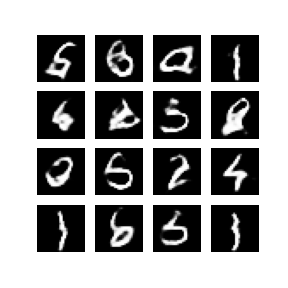

In [26]:
display_image(EPOCHS)

Use `imageio` to create an animated gif using the images saved during training.

In [27]:
anim_file = 'dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  filenames = glob.glob('image*.png')
  filenames = sorted(filenames)
  last = -1
  for i,filename in enumerate(filenames):
    frame = 2*(i**0.5)
    if round(frame) > round(last):
      last = frame
    else:
      continue
    image = imageio.imread(filename)
    writer.append_data(image)
  image = imageio.imread(filename)
  writer.append_data(image)

import IPython
if IPython.version_info > (6,2,0,''):
  display.Image(filename=anim_file)

If you're working in Colab you can download the animation with the code below:

In [28]:
try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(anim_file)

## Next steps


This tutorial has shown the complete code necessary to write and train a GAN. As a next step, you might like to experiment with a different dataset, for example the Large-scale Celeb Faces Attributes (CelebA) dataset [available on Kaggle](https://www.kaggle.com/jessicali9530/celeba-dataset). To learn more about GANs we recommend the [NIPS 2016 Tutorial: Generative Adversarial Networks](https://arxiv.org/abs/1701.00160).
